In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from numpy import datetime64
from ipywidgets import interact 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm

In [2]:
#Custom functions and some extra requirements
from numpy.fft import fft, ifft, fftfreq, rfftfreq, rfft, irfft

#Returns the area to explore, along with feature names of the features with less than threshold percentage of nans.
def explore_nulls(cube,lat = -4.21, lon = -69.94, threshold = 25,spacing = 5):
    area_to_explore = cube.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing))
    snull = area_to_explore.isnull()
    nnull = area_to_explore.notnull()
    viable_features=[]
    for i in area_to_explore.keys():
        count_null = snull[i].values.sum()
        count_nnull = nnull[i].values.sum()
        null_percentage = count_null/(count_null+count_nnull)*100
        if(null_percentage < threshold):
            print(i, "null_percentage = {:.2f}".format(null_percentage))
            viable_features.append(i)
    return area_to_explore, viable_features

#Authored by SaumyaBansal, lists the N highest values of a list
def Nmax(list1, N = 5): 
    final_list = [] 
    
    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j];
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list
    
#Find the indexes corresponding to the position of the values of list_of_max in array.
def find_Index(array,list_of_max):
    indexes = []
    for i in range(len(list_of_max)):
            indexes.append(np.argwhere(array == list_of_max[i])[0][0])
    return indexes    


#Makes zero the Fourier coefficients of farray bigger than  thethreshold.
def clean_periodicity(farray, list_of_maxes, list_of_indexes, threshold = 5):
    for i in range(len(list_of_maxes)):
        if(list_of_maxes[i]> threshold):
            farray[list_of_indexes[i]] = 0
            
            
#Returns a pandas DataFrame with the seasonality-corrected viable features.
def clean_cube(cube, central_lat, central_lon, spacing, threshold = 25):
    cube_section, features = explore_nulls(cube,lat = central_lat, lon = central_lon,threshold = threshold,spacing = spacing)
    series = []
    cube_section.load() #RAM expensive, avoid large spacing values.
    for feature in features:
        series.append(clean_feature(cube_section, feature))
    
    #return pd.concat(series, axis=1)
    return series

# panda Series with the spatial median of the corrected feature.
def clean_feature(cube_section, feature_name, fourier_threshold = 8):
    time_Series = cube_section[feature_name].dropna(dim='time').median(dim=['lat','lon'],skipna=True)
    freq = rfftfreq(len(time_Series.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
    f_time_Series = rfft(time_Series)
    
    real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
    imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
    real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
    imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)
    
    clean_periodicity(f_time_Series.real,real_maxes,real_ii)
    clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii)
    
    corrected_time_Series = irfft(f_time_Series, n = len(time_Series))

    #Creates a new series 
    final_Series = pd.Series(corrected_time_Series)
    dates = np.datetime_as_string(cube_section[feature_name].dropna(dim='time').coords['time'].values,unit = 'Y')
    final_Series.index = dates
    
    return final_Series

In [3]:
from esdl.cube_store import CubesStore
cs = CubesStore()
cs

CUBE_V2.0.0_global_spatially_optimized_0.25deg,Global data cube at a spatial resolution of 0.25 degrees and a temporal resolution of 8 days with a 1x720x1440 (time x lat x lon) chunking
CUBE_V2.0.0_global_time_optimized_0.25deg,Global data cube at a spatial resolution of 0.25 degrees and a temporal resolution of 8 days with a 184x90x90 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_spatially_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.0_global_spatially_optimized_0.083deg,Global data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x2160x4320 (time x lat x lon) chunking
CUBE_V2.0.0_global_time_optimized_0.083deg,Global data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 184x270x270 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_spatially_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.0083 degrees and a temporal resolution of 8 days with a 1x3360x2760 (time x lat x lon) chunking
CUBE_V2.0.0_colombia_time_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.0083 degrees and a temporal resolution of 8 days with a 184x60x60 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_spatially_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_time_optimized_0.083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_spatially_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking
CUBE_V2.0.1_colombia_time_optimized_0.0083deg,Colombian data cube at a spatial resolution of 0.083 degrees and a temporal resolution of 8 days with a 1x336x276 (time x lat x lon) chunking


In [4]:
#cube_high_res = xr.open_zarr("/home/jovyan/work/datacube/ESDCv2.0.0/esdc-8d-0.083deg-184x270x270-2.0.0.zarr")
cube_high_res = cs['CUBE_V2.0.0_global_time_optimized_0.083deg']
#cube_low_res = xr.open_zarr("/home/jovyan/work/datacube/ESDCv2.0.0/esdc-8d-0.25deg-184x90x90-2.0.0.zarr")
#cube_low_res = cs['CUBE_V2.0.0_global_time_optimized_0.25deg']


In [11]:
colombia,features = explore_nulls(cube_high_res,spacing=0.5, threshold=10, lat=48.15,lon=11.58)


black_sky_albedo_avhrr null_percentage = 5.42
fapar_tip null_percentage = 5.41
leaf_area_index null_percentage = 5.41
precipitation null_percentage = 5.35
white_sky_albedo_avhrr null_percentage = 5.42


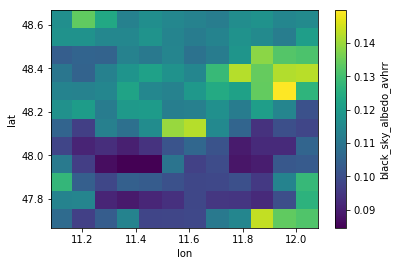

In [12]:
colombia.black_sky_albedo_avhrr.dropna(dim='time').mean(dim='time').plot()

In [13]:
test = colombia.copy()
#test = test[features[0]].sel(time='1990-01-05').values
#np.median(test)
#print(test[features[0]].shape)

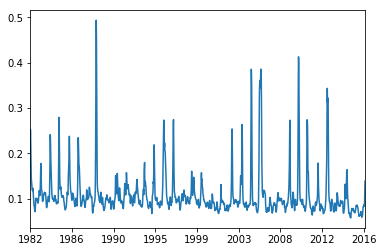

In [14]:
#By default xarray uses dask arrays. Sadly, dask does not have an implementation of median
testSeries = pd.Series(np.median(test[features[0]].dropna(dim='time'),axis=[1,2]))
dates = np.datetime_as_string(test[features[0]].dropna(dim='time').coords['time'].values,unit = 'Y')
testSeries.index = dates
testSeries.plot()

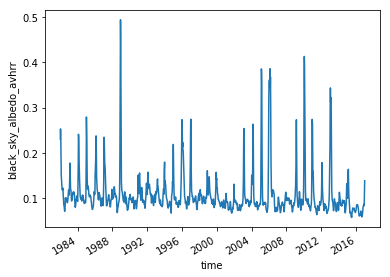

In [15]:
#It is possible to force xarray to not use dask array, using dataset.load(). It is RAM expensive.
test.load()
test[features[0]].dropna(dim='time').median(dim=['lat','lon'],skipna=True).plot()
#test[features[2]].median(dim=['lat','lon']).dropna(dim='time').plot()

In [16]:
len(test[features[0]].dropna(dim='time').median(dim=['lat','lon'],skipna=True))

1608

45.94285714285715

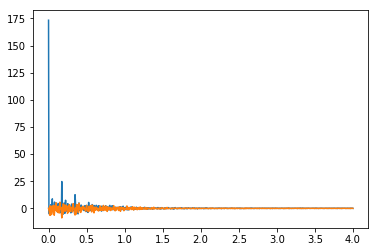

In [17]:
#First a particular case.
try0 = test[features[0]].dropna(dim='time').median(dim=['lat','lon'],skipna=True) #median on the small square
freq = rfftfreq(len(try0.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
ftry0 = rfft(try0)
plt.plot(freq,ftry0.real)
plt.plot(freq,ftry0.imag)
freq[35]**-1*8

In [18]:
maxesR= Nmax(np.abs(ftry0.real).tolist())
maxesI= Nmax(np.abs(ftry0.imag).tolist())
iiR = find_Index(np.abs(ftry0.real), maxesR)
iiI = find_Index(np.abs(ftry0.imag), maxesI)
maxesR, iiR

([173.35779761523008,
  24.70747025935112,
  12.570661952364457,
  8.742409311448272,
  7.464594324647744],
 [0, 35, 70, 10, 45])

In [19]:
clean_periodicity(ftry0.real,maxesR,iiR)
clean_periodicity(ftry0.imag,maxesI,iiI)

321.6

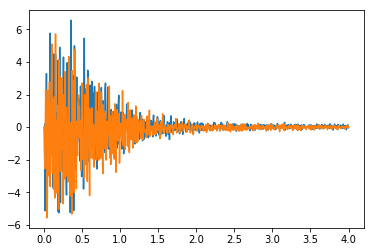

In [20]:
#Plots the new Fourier space
plt.plot(freq,ftry0.real)
plt.plot(freq,ftry0.imag)
#plt.xlim(0.165,0.18)
freq[5]**-1*8

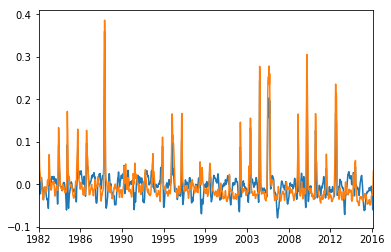

In [21]:
#Inverse transforms the new Fourier space.
try0_result = irfft(ftry0, n = len(try0))

#Creates a new series for easy plotting
testSeries2 = pd.Series(try0_result)
dates = np.datetime_as_string(test[features[0]].dropna(dim='time').coords['time'].values,unit = 'Y')
testSeries2.index = dates
testSeries2.plot() #Seasonality corrected (blue)
(testSeries-np.mean(try0.values)).plot() #without correction (orange). I substracted the mean for easy comparision.



In [24]:
#The plan is to create a pandas DataFrame to store the seasonally corrected section of the cube.
amazon, features = explore_nulls(cube_high_res,spacing=1, threshold=49)#Default centered in Leticia.
amazon.load()

black_sky_albedo_avhrr null_percentage = 5.42
fapar_tip null_percentage = 5.41
leaf_area_index null_percentage = 5.41
mask null_percentage = 47.71
precipitation null_percentage = 5.35
white_sky_albedo_avhrr null_percentage = 5.42


<xarray.Dataset>
Dimensions:                            (bnds: 2, lat: 24, lon: 24, time: 1702)
Coordinates:
  * lat                                (lat) float32 -3.2912934 ... -5.2079525
    lat_bnds                           (lat, bnds) float32 -3.33296 ... -5.166286
  * lon                                (lon) float32 -70.875435 ... -68.95878
    lon_bnds                           (lon, bnds) float32 -70.91711 ... -68.917114
  * time                               (time) datetime64[ns] 1980-01-05 ... 2016-12-30
    time_bnds                          (time, bnds) datetime64[ns] 1980-01-05 ... 2017-01-05
Dimensions without coordinates: bnds
Data variables:
    Rg                                 (time, lat, lon) float32 nan ... 166.8
    aerosol_optical_thickness_1600     (time, lat, lon) float32 nan nan ... nan
    aerosol_optical_thickness_550      (time, lat, lon) float32 nan nan ... nan
    aerosol_optical_thickness_670      (time, lat, lon) float32 nan nan ... nan
    aerosol_optic

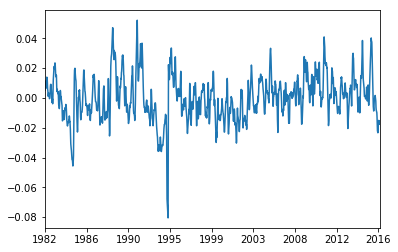

In [25]:
corrected = clean_feature(amazon, features[5])
corrected.plot()


In [46]:
lat = -4.21
lon = -69.94

hail_Satan = clean_cube(cube_high_res, central_lat=lat, central_lon=lon, spacing = 1)

black_sky_albedo_avhrr null_percentage = 5.42
fapar_tip null_percentage = 5.41
leaf_area_index null_percentage = 5.41
precipitation null_percentage = 5.35
white_sky_albedo_avhrr null_percentage = 5.42


In [67]:
type(hail_Satan)

list

In [68]:
type(hail_Satan)

list

In [70]:
df = pd.concat(hail_Satan, axis=1)

ValueError: cannot reindex from a duplicate axis